In [1]:
import numpy as np
from scipy.integrate import solve_ivp, quad_vec
from scipy.linalg import expm, inv
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

In [2]:
def phi_A(t_1, t_2, A):
    return expm(A*(t_2-t_1))

def integrand(tau, t1, A, B):
    phi_tau = phi_A(t1, tau, A)
    return phi_tau @ B @ B.T @ phi_tau.T 

def M(t0, t1, A, B):
    # Define the integrand as a function of tau, the variable of integration
    def integrand(tau):
        phi_tau = phi_A(t1, tau, A)
        return phi_tau @ B @ B.T @ phi_tau.T

    # Initialize the matrix to be returned
    M_matrix = np.zeros((2, 2))

    # Integrate each element of the matrix using quad_vec
    for i in range(2):
        for j in range(2):
            # Define a lambda function for the current element
            element_integrand = lambda tau: integrand(tau)[i, j]
            # Perform the integration for the current element
            M_matrix[i, j], _ = quad_vec(element_integrand, t0, t1)
    return M_matrix

def P_0(Q0, Sigma_0_inv):
    return inv((Sigma_0_inv - inv(Q0)))

def P_T(T, P0, A, B):
    return phi_A(T, 0, A) @ P0 @ phi_A(T, 0, A).T + M(T, 0, A, B)

def Q_T(PT, Sigma_T_inv):
    return inv((Sigma_T_inv - inv(PT)))

def Q_0(T, QT, A, B):
    return phi_A(0, T, A) @ (QT + M(T, 0, A, B)) @ phi_A(0, T, A).T

# System parameters for inertial particles
# A(t) = [[0, 1], [0, 0]] for the system dx = v*dt, dv = u*dt + dw
# B(t) = [[0], [1]] since the control input u(t) only affects the acceleration
A_const = np.array([[0, 1], [0, 0]])
B_const = np.array([[0], [1]])

# Initial and terminal inverse covariance matrices for the Gaussian distributions
# Sigma_0 = I implies Sigma_0_inv = I
# Sigma_T = 1/4*I implies Sigma_T_inv = 4*I
Sigma_0_inv = np.eye(2)
Sigma_T_inv = 4*np.eye(2)

# Time span
T = 1  # Terminal time
t_span = (0, T)
t_eval = np.linspace(0, T, 100)  # Adjust the number of points as needed

Q0 = 2*np.eye(2)

# Example usage
M_example = M(0, 1, A_const, B_const)
M_example

for i in range(100):
    P0 = P_0(Q0, Sigma_0_inv)
    PT = P_T(T, P0, A_const, B_const)
    QT = Q_T(PT, Sigma_T_inv)
    Q0 = Q_0(T, QT, A_const, B_const)

print("P0=", P0)
print("PT=", PT)
print("QT=", QT)
print("Q0=", Q0)

P0= [[0.52294892 0.32763652]
 [0.32763652 0.23208009]]
PT= [[-0.23357736 -0.40444357]
 [-0.40444357 -0.76791991]]
QT= [[0.05643107 0.0769095 ]
 [0.0769095  0.15804232]]
Q0= [[-1.96504095 -1.26504818]
 [-1.26504818 -0.84195768]]


In [3]:
tolerance = 1e-3
assert np.allclose(inv(P0)+inv(Q0), Sigma_0_inv, atol=tolerance) 
assert np.allclose(inv(PT)+inv(QT), Sigma_T_inv, atol=tolerance) 

In [4]:
# The system of differential equations for Q
def system_Q(t, Q_flat, A, B):
    Q = Q_flat.reshape(A.shape)
    Q_dot = A @ Q + Q @ A.T - B @ B.T
    return Q_dot.flatten()

# The system of differential equations for P
def system_P(t, P_flat, A, B):
    P = P_flat.reshape(A.shape)
    P_dot = A @ P + P @ A.T + B @ B.T
    return P_dot.flatten()

# Residual function for the shooting method for Q
def residuals_Q(Q0_flat, Q_T_target, A, B, t_span):
    sol = solve_ivp(system_Q, t_span, Q0_flat, args=(A, B), method='RK45', dense_output=True)
    Q_final = sol.sol(t_span[1]).reshape(A.shape)
    res = Q_final - Q_T_target
    return res.flatten()

# Residual function for the shooting method for P
def residuals_P(P0_flat, P_T_target, A, B, t_span):
    sol = solve_ivp(system_P, t_span, P0_flat, args=(A, B), method='RK45', dense_output=True)
    P_final = sol.sol(t_span[1]).reshape(A.shape)
    res = P_final - P_T_target
    return res.flatten()

# Flatten the terminal matrices for use in fsolve
QT_target_flat = QT.flatten()
PT_target_flat = PT.flatten()

# Find the root of the residuals function for Q
Q0_opt_flat = fsolve(residuals_Q, Q0.flatten(), args=(QT, A_const, B_const, t_span))

# Find the root of the residuals function for P
P0_opt_flat = fsolve(residuals_P, P0.flatten(), args=(PT, A_const, B_const, t_span))

# Solve the IVP with the optimized initial conditions for Q
solution_Q = solve_ivp(system_Q, t_span, Q0_opt_flat, args=(A_const, B_const), method='RK45', t_eval=t_eval)

# Solve the IVP with the optimized initial conditions for P
solution_P = solve_ivp(system_P, t_span, P0_opt_flat, args=(A_const, B_const), method='RK45', t_eval=t_eval)

# Reshape the solutions into matrix form for analysis
Q_t_opt = solution_Q.y.reshape(2, 2, -1)
P_t_opt = solution_P.y.reshape(2, 2, -1)

# Final optimized matrices
Q_final_opt = Q_t_opt[:, :, -1]
P_final_opt = P_t_opt[:, :, -1]

Q_final_opt, P_final_opt

print(np.shape(Q_t_opt))

(2, 2, 100)


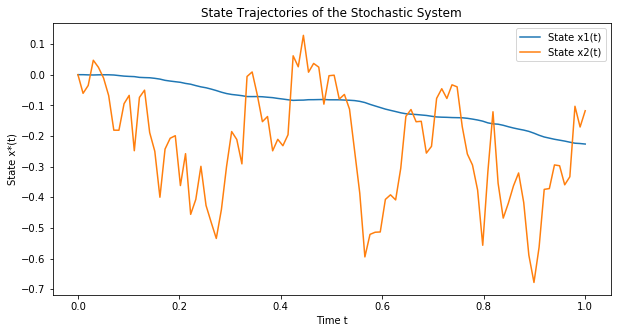

In [5]:
# Assuming the initial state is the zero vector
xi = np.array([0, 0])

# Number of simulation steps
N = len(t_eval)
dt = 1/N  # time increment

# Preallocate arrays to hold the simulation results
x_star_traj = np.zeros((2, N))
x_star_traj[:, 0] = xi  # Set initial condition

# Function to compute the control input within the SDE
def feedback_control(t, x, Q_t_func, B):
    Q_inv = inv(Q_t_func.reshape(2,2))
    return -B @ B.T @ Q_inv @ x

# Simulate the SDE using Euler-Maruyama method
for i in range(1, N):
    t = t_eval[i-1]
    dw = np.sqrt(dt) * np.random.randn(1)  # Delta w(t) for Wiener process
    feedback = feedback_control(t, x_star_traj[:, i-1], Q_t_opt[:, :, i-1], B_const)
    x_star_traj[:, i] = x_star_traj[:, i-1] + (A_const @ x_star_traj[:, i-1] + feedback) * dt + B_const.flatten() * dw

# Plot the trajectories of state x1 and x2
plt.figure(figsize=(10, 5))
plt.plot(t_eval, x_star_traj[0, :], label='State x1(t)')
plt.plot(t_eval, x_star_traj[1, :], label='State x2(t)')
plt.xlabel('Time t')
plt.ylabel('State x*(t)')
plt.title('State Trajectories of the Stochastic System')
plt.legend()
plt.show()

No handles with labels found to put in legend.


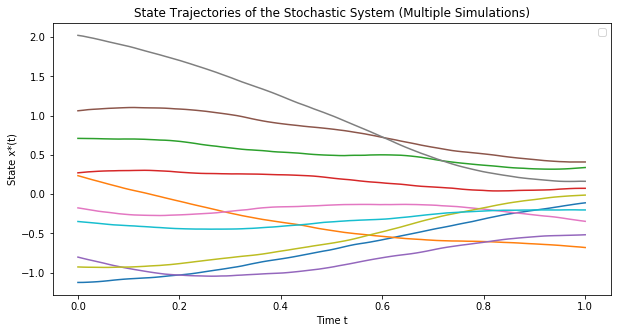

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define simulation parameters
num_simulations = 10  # Number of simulations
N = len(t_eval)
dt = 1 / N  # time increment

# Preallocate an array to hold all simulation trajectories
all_trajectories = []

# Loop for different random initializations
for _ in range(num_simulations):
    # Generate a random initial condition
    xi = np.random.multivariate_normal(mean=np.zeros(2), cov=inv(Sigma_0_inv))
    
    # Preallocate arrays to hold the simulation results
    x_star_traj = np.zeros((2, N))
    x_star_traj[:, 0] = xi  # Set initial condition
    
    # Simulate the SDE using Euler-Maruyama method
    for i in range(1, N):
        t = t_eval[i-1]
        dw = np.sqrt(dt) * np.random.randn(1)  # Delta w(t) for Wiener process
        feedback = feedback_control(t, x_star_traj[:, i-1], Q_t_opt[:, :, i-1], B_const)
        x_star_traj[:, i] = x_star_traj[:, i-1] + (A_const @ x_star_traj[:, i-1] + feedback) * dt + B_const.flatten() * dw
    
    # Store the trajectory in the list
    all_trajectories.append(x_star_traj)

# Plot all trajectories on one plot
plt.figure(figsize=(10, 5))
for i, trajectory in enumerate(all_trajectories):
    plt.plot(t_eval, trajectory[0, :])
    
plt.xlabel('Time t')
plt.ylabel('State x*(t)')
plt.title('State Trajectories of the Stochastic System (Multiple Simulations)')
plt.legend()
plt.show()


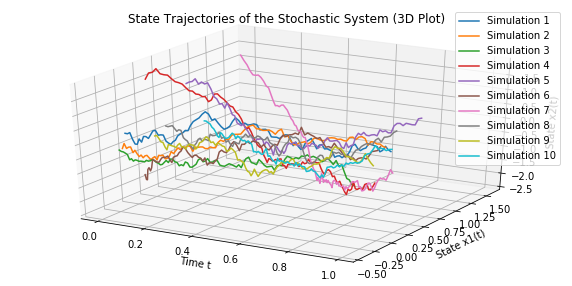

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting module

# Define simulation parameters
num_simulations = 10  # Number of simulations
N = len(t_eval)
dt = 1 / N  # time increment


# Preallocate an array to hold all simulation trajectories
all_trajectories = []

# Loop for different random initializations
for _ in range(num_simulations):
    # Generate a random initial condition xi with the specified density
    xi = np.random.multivariate_normal(mean=np.zeros(2), cov=inv(Sigma_0_inv))
    
    # Preallocate arrays to hold the simulation results
    x_star_traj = np.zeros((2, N))
    x_star_traj[:, 0] = xi  # Set initial condition
    
    # Simulate the SDE using Euler-Maruyama method
    for i in range(1, N):
        t = t_eval[i-1]
        dw = np.sqrt(dt) * np.random.randn(1)  # Delta w(t) for Wiener process
        feedback = feedback_control(t, x_star_traj[:, i-1], Q_t_opt[:, :, i-1], B_const)
        x_star_traj[:, i] = x_star_traj[:, i-1] + (A_const @ x_star_traj[:, i-1] + feedback) * dt + B_const.flatten() * dw
    
    # Store the trajectory in the list
    all_trajectories.append(x_star_traj)

# Create a 3D plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

# Plot all trajectories in 3D space
for i, trajectory in enumerate(all_trajectories):
    time = np.arange(0, N) * dt
    state_1 = trajectory[0, :]
    state_2 = trajectory[1, :]
    
    ax.plot(time, state_1, state_2, label=f'Simulation {i+1}')

ax.set_xlabel('Time t')
ax.set_ylabel('State x1(t)')
ax.set_zlabel('State x2(t)')
ax.set_title('State Trajectories of the Stochastic System (3D Plot)')
ax.legend()
plt.show()


In [8]:
import numpy as np
import plotly.graph_objects as go

# Define simulation parameters
num_simulations = 10  # Number of simulations
N = len(t_eval)
dt = 1 / N  # time increment

# Create a figure for the 3D plot
fig = go.Figure()

# Loop for different random initializations
for sim_num in range(num_simulations):
    # Generate a random initial condition xi with the specified density
    xi = np.random.multivariate_normal(mean=np.zeros(2), cov=inv(Sigma_0_inv))
    
    # Preallocate arrays to hold the simulation results
    x_star_traj = np.zeros((2, N))
    x_star_traj[:, 0] = xi  # Set initial condition
    
    # Simulate the SDE using Euler-Maruyama method
    for i in range(1, N):
        t = t_eval[i-1]
        dw = np.sqrt(dt) * np.random.randn(1)  # Delta w(t) for Wiener process
        feedback = feedback_control(t, x_star_traj[:, i-1], Q_t_opt[:, :, i-1], B_const)
        x_star_traj[:, i] = x_star_traj[:, i-1] + (A_const @ x_star_traj[:, i-1] + feedback) * dt + B_const.flatten() * dw
    
    # Store the trajectory data for the 3D plot
    time = np.arange(0, N) * dt
    state_1 = x_star_traj[0, :]
    state_2 = x_star_traj[1, :]
    
    fig.add_trace(go.Scatter3d(x=time, y=state_1, z=state_2, mode='lines', name=f'Simulation {sim_num+1}'))

# Set axis labels and title
fig.update_layout(scene=dict(xaxis_title='Time t', yaxis_title='x(t)', zaxis_title='v(t)'),
                  title='State Trajectories of the Stochastic System (3D Plot)')

# Show the 3D plot
fig.show()


In [9]:
# Set axis labels and title
fig.update_layout(scene=dict(xaxis_title='Time t', yaxis_title='x(t)', zaxis_title='v(t)',
                    xaxis = dict(nticks=5, range=[0,1],),
                    yaxis = dict(nticks=5, range=[-5,5],),
                    zaxis = dict(nticks=5, range=[-4,4])),
                  title='State Trajectories of the Stochastic System (3D Plot)'), 

# Show the 3D plot
fig.show()

In [10]:
import plotly.graph_objs as go
import numpy as np


# Define the range of timesteps
timesteps = np.linspace(0, 1, 50)

# Initialize data list for Plotly
data = []

# Generate circles for each timestep
for t in range(np.shape(Q_t_opt)[2]):
    r = 1 / sigma(t)  # Radius at this timestep
    theta = np.linspace(0, 2 * np.pi, 100)
    x = r * np.cos(theta)
    v = r * np.sin(theta)
    
    # Create a scatter plot for this circle
    circle = go.Scatter3d(x=x, y=[t]*len(theta), z=v, mode='lines', name=f't={t:.2f}')
    data.append(circle)

# Layout for the 3D plot
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='Position x'),
        yaxis=dict(title='Time t'),
        zaxis=dict(title='Velocity v'),
        aspectmode='cube'  # Equal aspect ratio
    )
)

# Create the figure
fig = go.Figure(data=data, layout=layout)

# Loop for different random initializations
for sim_num in range(num_simulations):
    # Generate a random initial condition xi with the specified density
    xi = np.random.multivariate_normal(mean=np.zeros(2), cov=inv(Sigma_0_inv))
    
    # Preallocate arrays to hold the simulation results
    x_star_traj = np.zeros((2, N))
    x_star_traj[:, 0] = xi  # Set initial condition
    
    # Simulate the SDE using Euler-Maruyama method
    for i in range(1, N):
        t = t_eval[i-1]
        dw = np.sqrt(dt) * np.random.randn(1)  # Delta w(t) for Wiener process
        feedback = feedback_control(t, x_star_traj[:, i-1], Q_t_opt[:, :, i-1], B_const)
        x_star_traj[:, i] = x_star_traj[:, i-1] + (A_const @ x_star_traj[:, i-1] + feedback) * dt + B_const.flatten() * dw
    
    # Store the trajectory data for the 3D plot
    time = np.arange(0, N) * dt
    state_1 = x_star_traj[0, :]
    state_2 = x_star_traj[1, :]
    
    fig.add_trace(go.Scatter3d(y=time, x=state_1, z=state_2, mode='lines', name=f'Simulation {sim_num+1}'))

# Set axis labels and title
fig.update_layout(scene=dict(yaxis_title='Time t', xaxis_title='x(t)', zaxis_title='v(t)'),
                  title='State Trajectories of the Stochastic System (3D Plot)')


# Plot the figure
fig.show()


NameError: name 'sigma' is not defined

In [ ]:
import plotly.graph_objs as go
import numpy as np

cov_invs = np.zeros_like(Q_t_opt)

def plot_ellipse(cov_inv, t, ax):
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov_inv)

    # Angle array
    angle = np.linspace(0, 2 * np.pi, 100)

    # The unit circle
    circle = np.array([np.cos(angle), np.sin(angle)])

    # Scaling the circle to the ellipse with the eigenvalues and multiplying by 3 for 3-sigma
    ellipse = np.sqrt(eigenvalues[:, np.newaxis]) * eigenvectors @ circle * 3

    # Plot the ellipse
    ax.add_trace(go.Scatter3d(
        x=ellipse[0, :],
        y=[t] * len(angle),
        z=ellipse[1, :],
        mode='lines'
    ))

# Define your covariance matrices for each time step here
cov_invs = [...]  # List of covariance matrix inverses for each time step

# Create a Plotly figure
fig = go.Figure()

# Plot ellipses for each time step
for i in range(np.shape(Q_t_opt)[2]):
    print(i)
    cov_invs[:,:,i] = inv(Q_t_opt[:,:,i]) + inv(P_t_opt[:,:,i])
    cov_inv = cov_invs[:,:,i]
    t = i / np.shape(Q_t_opt)[2]  # Normalized time step
    plot_ellipse(cov_inv, t, fig)

# Define layout
fig.update_layout(
    scene=dict(
        xaxis_title='x',
        yaxis_title='Time',
        zaxis_title='v',
        aspectmode='cube'
    )
)

# Show the figure
fig.show()
